### Evalution of LLM Applications 

## Outline:

* Example generation
* Manual evaluation (and debuging)
* LLM-assisted evaluation
* LangChain evaluation platform

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

### Create our QandA application

In [3]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch

file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)
data = loader.load()

index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

llm = ChatOpenAI(temperature = 0.0, model=llm_model)
qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=index.vectorstore.as_retriever(), 
    verbose=True,
    chain_type_kwargs = {
        "document_separator": "<<<<>>>>>"
    }
)

#### Coming up with test datapoints

In [4]:
data[10]

Document(page_content=": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded hem.\n- Pull-on pants have a wide elastic waistband and drawstring, side pockets and a modern slim leg.\n\nImported.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 10})

In [5]:
data[11]

Document(page_content=': 11\nname: Ultra-Lofty 850 Stretch Down Hooded Jacket\ndescription: This technical stretch down jacket from our DownTek collection is sure to keep you warm and comfortable with its full-stretch construction providing exceptional range of motion. With a slightly fitted style that falls at the hip and best with a midweight layer, this jacket is suitable for light activity up to 20° and moderate activity up to -30°. The soft and durable 100% polyester shell offers complete windproof protection and is insulated with warm, lofty goose down. Other features include welded baffles for a no-stitch construction and excellent stretch, an adjustable hood, an interior media port and mesh stash pocket and a hem drawcord. Machine wash and dry. Imported.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 11})

#### Hard-coded examples

Now based on above Product Name and Description. We will create queries and there examples

In [6]:
examples = [
    {
        'qa_pairs':  {
        "query": "Do the Cozy Comfort Pullover Set\
        have side pockets?",
        "answer": "Yes"
    }
    },
    {
        'qa_pairs' :  {
        "query": "What collection is the Ultra-Lofty \
        850 Stretch Down Hooded Jacket from?",
        "answer": "The DownTek collection"
    }
    }
]

So now .based on above 2 docs[10] and docs[11] .We created 2 QueryAnswer.

Similarly we will create QueryAnswer from all the docs we have till now using QAGenerateChain 

In [7]:
from langchain.evaluation.qa import QAGenerateChain
example_gen_chain = QAGenerateChain.from_llm(ChatOpenAI(model=llm_model))
new_examples = example_gen_chain.apply_and_parse(
    [{"doc": t} for t in data[:5]]
)
new_examples[0]

e:\Github\LLM\.conda\lib\site-packages\langchain\chains\llm.py:306: UserWarning: The apply_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please 

{'qa_pairs': {'query': "What is the weight of each pair of Women's Campside Oxfords?",
  'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb. 1 oz."}}

In [30]:
new_examples

[{'qa_pairs': {'query': "What is the weight of each pair of Women's Campside Oxfords?",
   'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb.1 oz."}},
 {'qa_pairs': {'query': 'What are the dimensions of the small and medium Recycled Waterhog dog mats?',
   'answer': 'The dimensions of the small Recycled Waterhog dog mat are 18" x 28" and the dimensions of the medium Recycled Waterhog dog mat are 22.5" x 34.5".'}},
 {'qa_pairs': {'query': "What features does the Infant and Toddler Girls' Coastal Chill Swimsuit have?",
   'answer': "The swimsuit has bright colors, ruffles, and exclusive whimsical prints. It is made of four-way-stretch and chlorine-resistant fabric that keeps its shape and resists snags. The swimsuit is also UPF 50+ rated, providing high-rated sun protection that blocks 98% of the sun's harmful rays. Additionally, the swimsuit has crossover no-slip straps and a fully lined bottom to ensure a secure fit and maximum coverage. Finally, the sw

In [8]:
data[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

Now we will add this new examples in example created by ourselves

In [9]:
examples += new_examples
examples

[{'qa_pairs': {'query': 'Do the Cozy Comfort Pullover Set        have side pockets?',
   'answer': 'Yes'}},
 {'qa_pairs': {'query': 'What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?',
   'answer': 'The DownTek collection'}},
 {'qa_pairs': {'query': "What is the weight of each pair of Women's Campside Oxfords?",
   'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb. 1 oz."}},
 {'qa_pairs': {'query': 'What is the material used to make the Recycled Waterhog dog mat?',
   'answer': 'The Recycled Waterhog dog mat is made from 24 oz. polyester fabric made from 94% recycled materials.'}},
 {'qa_pairs': {'query': "What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?",
   'answer': 'The swimsuit features bright colors, ruffles, exclusive whimsical prints, four-way-stretch and chlorine-resistant fabric, UPF 50+ rated fabric for sun protection, crossover no-slip straps, fully lined bottom, and mach

In [10]:
qa.run(examples[0]['qa_pairs']["query"])



> Entering new RetrievalQA chain...

> Finished chain.


'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'

We are not above get What was the prompt used. What Documents were passed.

In [11]:
import langchain
langchain.debug = True

qa.run(examples[0]['qa_pairs']["query"])

[chain/start] [1:chain:RetrievalQA] Entering Chain run with input:
{
  "query": "Do the Cozy Comfort Pullover Set        have side pockets?"
}
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:RetrievalQA > 3:chain:StuffDocumentsChain > 4:chain:LLMChain] Entering Chain run with input:
{
  "question": "Do the Cozy Comfort Pullover Set        have side pockets?",
  "context": ": 10\nname: Cozy Comfort Pullover Set, Stripe\ndescription: Perfect for lounging, this striped knit set lives up to its name. We used ultrasoft fabric and an easy design that's as comfortable at bedtime as it is when we have to make a quick run out.\n\nSize & Fit\n- Pants are Favorite Fit: Sits lower on the waist.\n- Relaxed Fit: Our most generous fit sits farthest from the body.\n\nFabric & Care\n- In the softest blend of 63% polyester, 35% rayon and 2% spandex.\n\nAdditional Features\n- Relaxed fit top with raglan sleeves and rounded h

'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'

In [12]:
# Turn off the debug mode
langchain.debug = False

This is Just for Single Example.

How we will evaluate for other different Examples 

#### LLM assisted evaluation

In [13]:
for i in range(len(examples)):
    examples[i]= examples[i]['qa_pairs']
examples

[{'query': 'Do the Cozy Comfort Pullover Set        have side pockets?',
  'answer': 'Yes'},
 {'query': 'What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?',
  'answer': 'The DownTek collection'},
 {'query': "What is the weight of each pair of Women's Campside Oxfords?",
  'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb. 1 oz."},
 {'query': 'What is the material used to make the Recycled Waterhog dog mat?',
  'answer': 'The Recycled Waterhog dog mat is made from 24 oz. polyester fabric made from 94% recycled materials.'},
 {'query': "What are the features of the Infant and Toddler Girls' Coastal Chill Swimsuit, Two-Piece?",
  'answer': 'The swimsuit features bright colors, ruffles, exclusive whimsical prints, four-way-stretch and chlorine-resistant fabric, UPF 50+ rated fabric for sun protection, crossover no-slip straps, fully lined bottom, and machine wash and line dry for best results.'},
 {'query': 'What is the fabric 

In [14]:
## First we predict for all the examples we have

predictions = qa.apply(examples)
predictions 



> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


> Entering new RetrievalQA chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


[{'query': 'Do the Cozy Comfort Pullover Set        have side pockets?',
  'answer': 'Yes',
  'result': 'The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.'},
 {'query': 'What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?',
  'answer': 'The DownTek collection',
  'result': 'The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.'},
 {'query': "What is the weight of each pair of Women's Campside Oxfords?",
  'answer': "The approximate weight of each pair of Women's Campside Oxfords is 1 lb. 1 oz.",
  'result': "The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz."},
 {'query': 'What is the material used to make the Recycled Waterhog dog mat?',
  'answer': 'The Recycled Waterhog dog mat is made from 24 oz. polyester fabric made from 94% recycled materials.',
  'result': 'The Recycled Waterhog dog mat is made from 24 oz. polyester fabric made from 94% recycled materials with a rubber 

In [15]:
from langchain.evaluation.qa import QAEvalChain
llm = ChatOpenAI(temperature=0, model=llm_model)
eval_chain = QAEvalChain.from_llm(llm)
graded_outputs = eval_chain.evaluate(examples, predictions)
graded_outputs



Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co

[{'results': 'CORRECT'},
 {'results': 'CORRECT'},
 {'results': 'CORRECT'},
 {'results': 'CORRECT'},
 {'results': 'CORRECT'},
 {'results': 'CORRECT'},
 {'results': 'CORRECT'}]

In [17]:
for i, eg in enumerate(examples):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer'])
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['results'])
    print()

graded_outputs[0]

Example 0:
Question: Do the Cozy Comfort Pullover Set        have side pockets?
Real Answer: Yes
Predicted Answer: The Cozy Comfort Pullover Set, Stripe has side pockets on the pull-on pants.
Predicted Grade: CORRECT

Example 1:
Question: What collection is the Ultra-Lofty         850 Stretch Down Hooded Jacket from?
Real Answer: The DownTek collection
Predicted Answer: The Ultra-Lofty 850 Stretch Down Hooded Jacket is from the DownTek collection.
Predicted Grade: CORRECT

Example 2:
Question: What is the weight of each pair of Women's Campside Oxfords?
Real Answer: The approximate weight of each pair of Women's Campside Oxfords is 1 lb. 1 oz.
Predicted Answer: The weight of each pair of Women's Campside Oxfords is approximately 1 lb. 1 oz.
Predicted Grade: CORRECT

Example 3:
Question: What is the material used to make the Recycled Waterhog dog mat?
Real Answer: The Recycled Waterhog dog mat is made from 24 oz. polyester fabric made from 94% recycled materials.
Predicted Answer: The R

{'results': 'CORRECT'}

#### Langchain Evalutation Platform 

The LangChain evaluation platform, LangChain Plus, can be accessed here https://www.langchain.plus/.  
Use the invite code `lang_learners_2023`



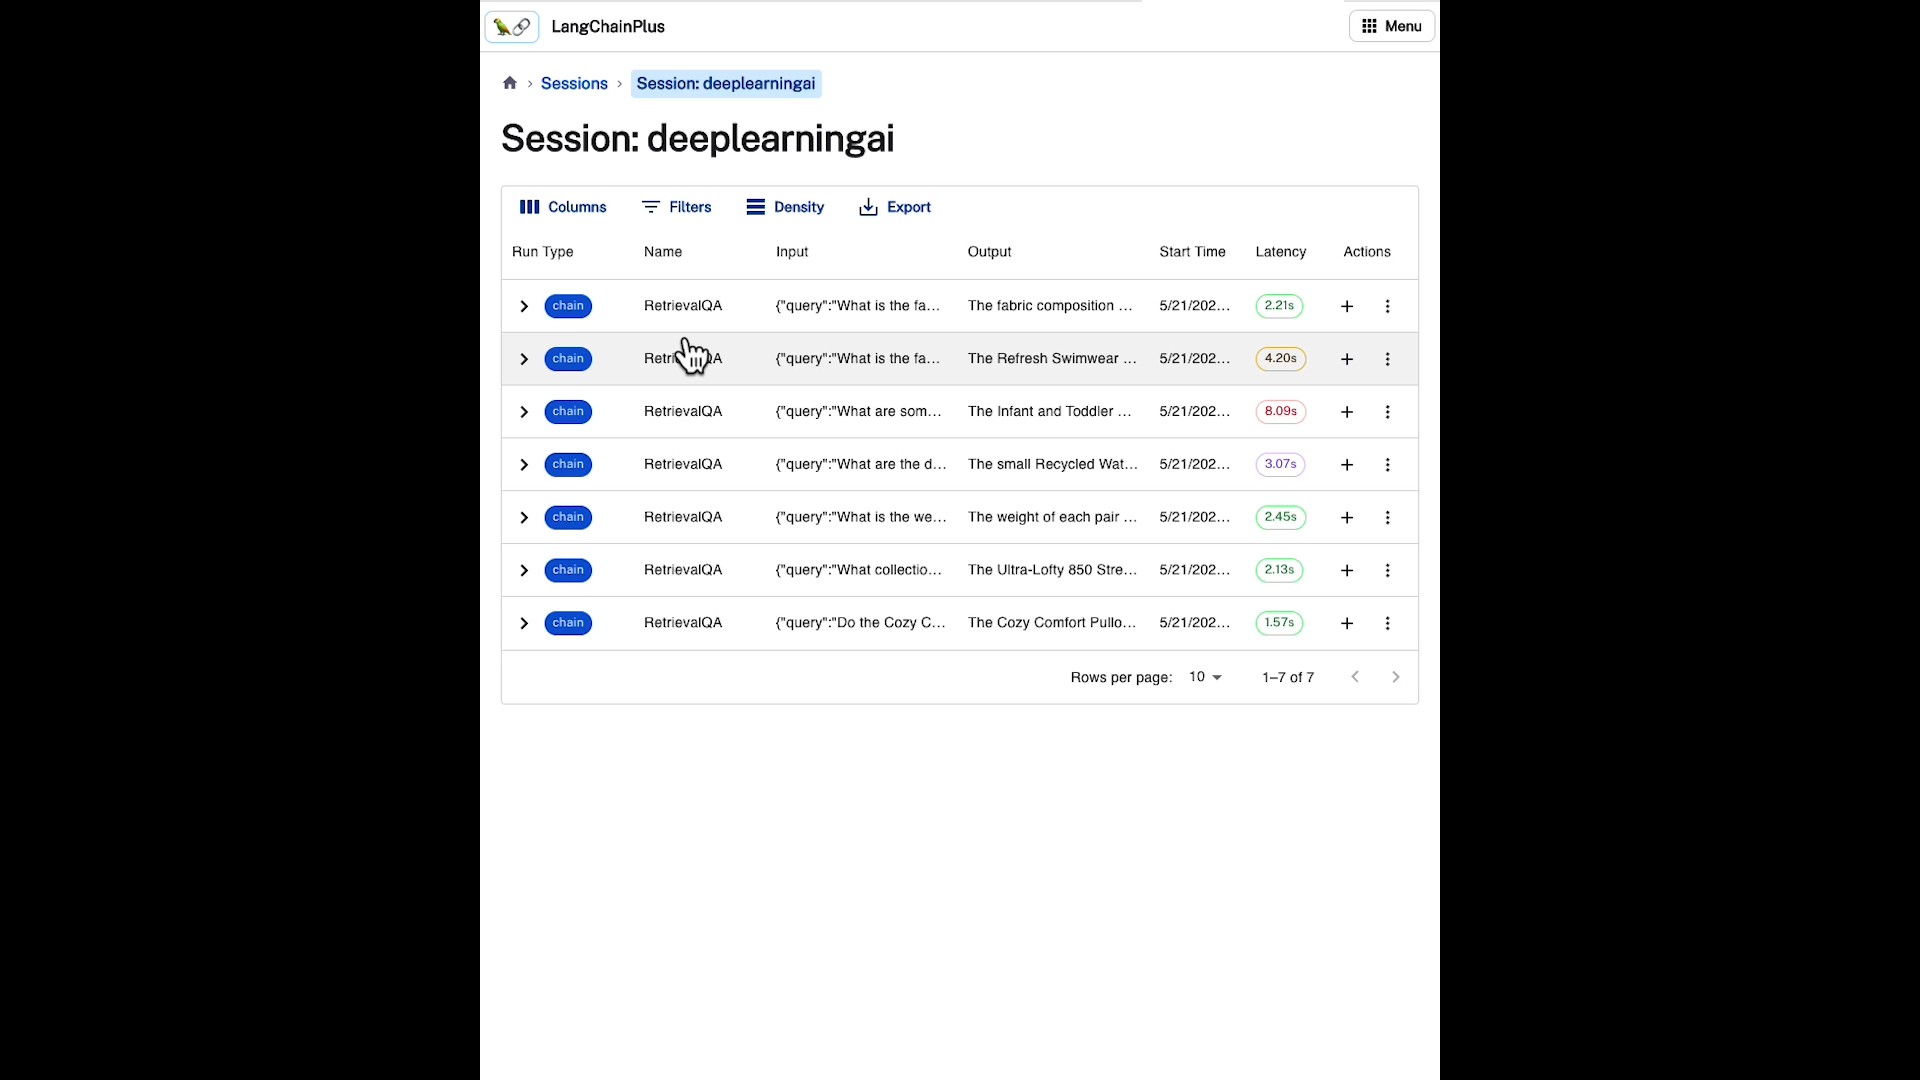

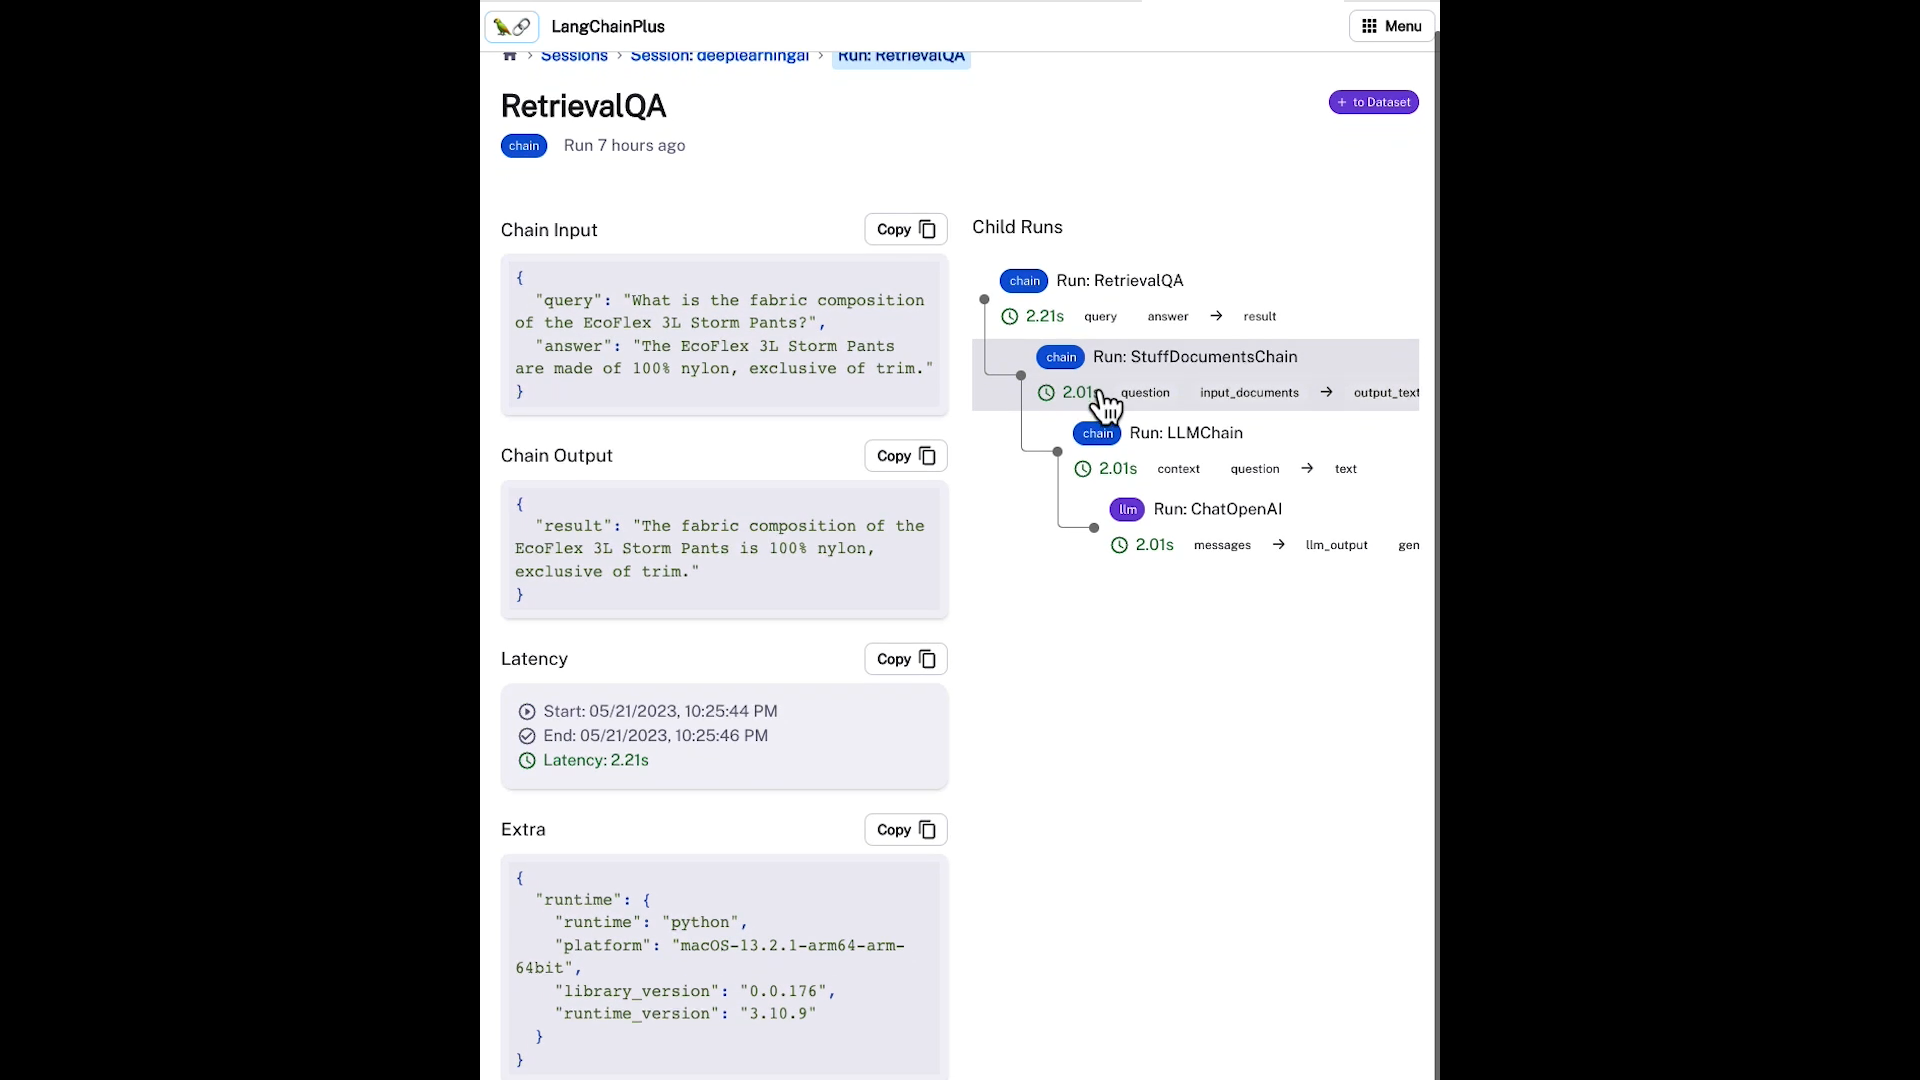

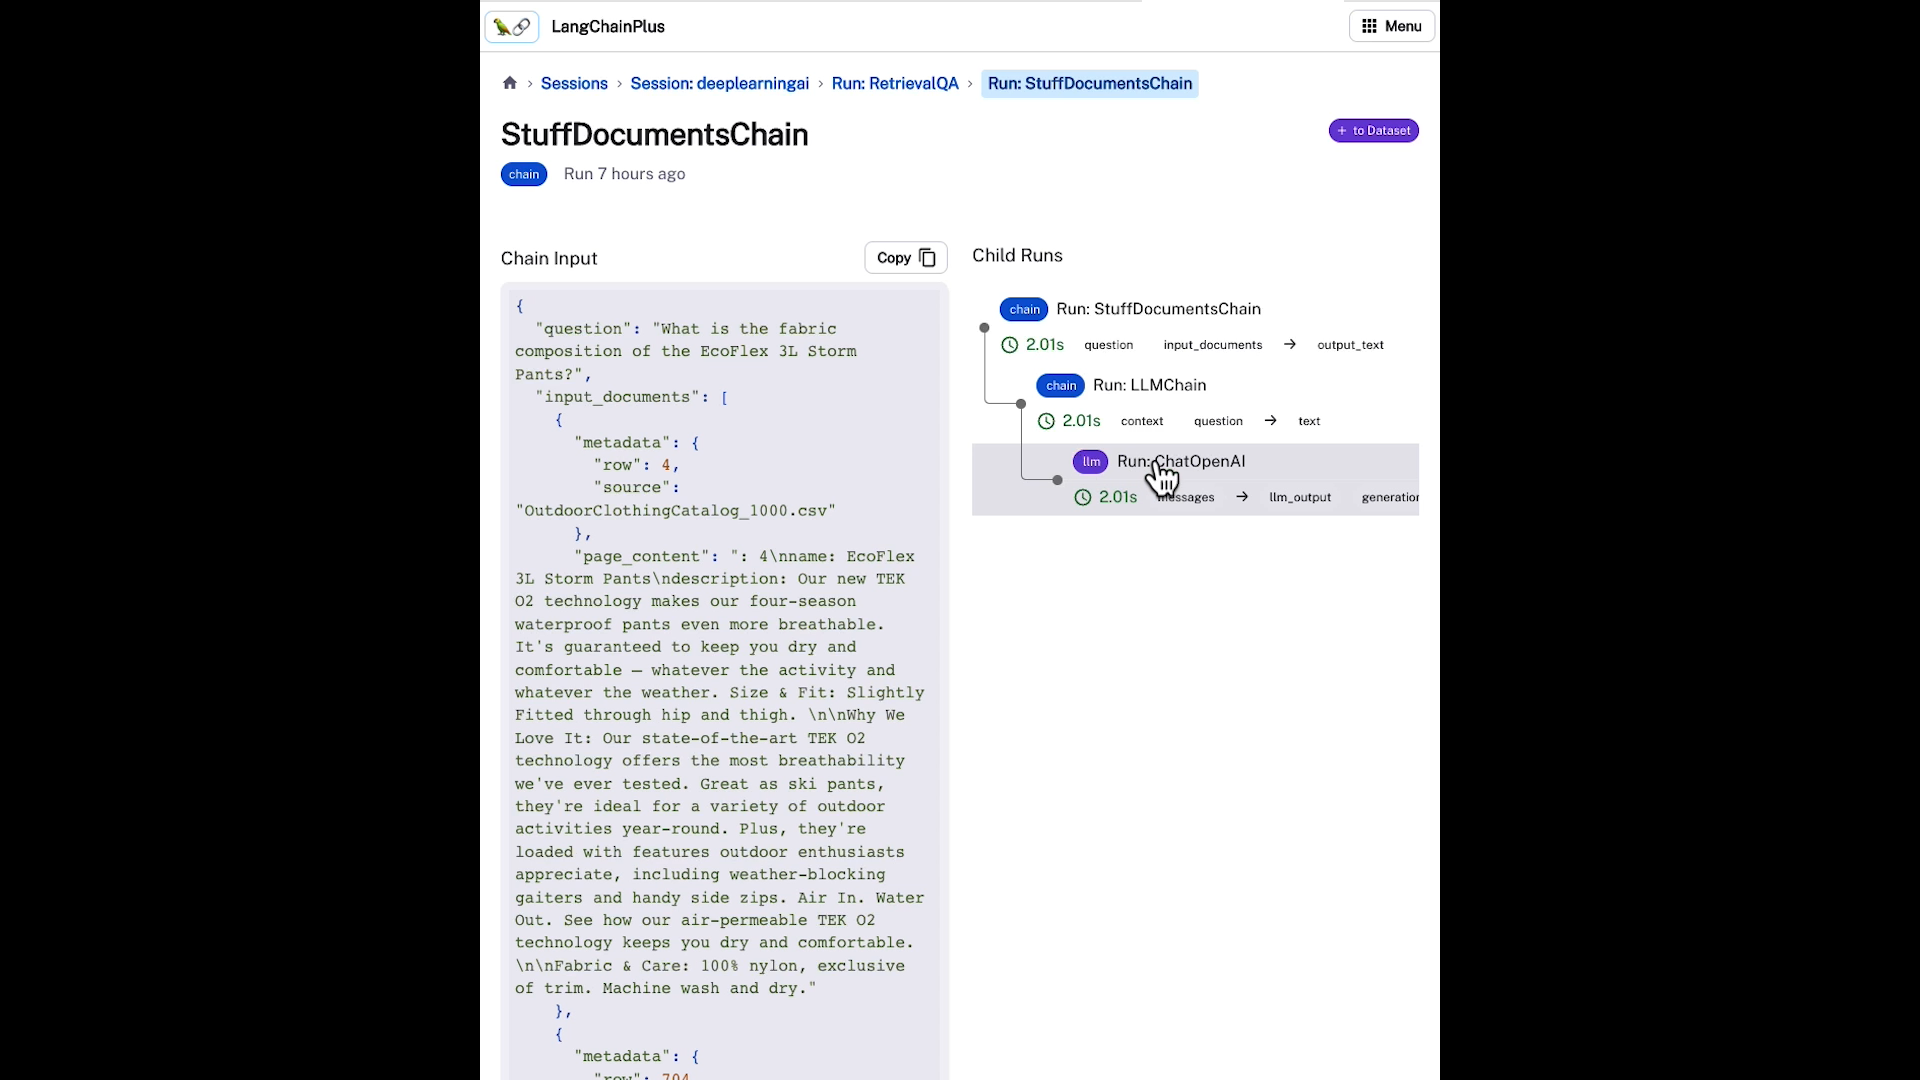

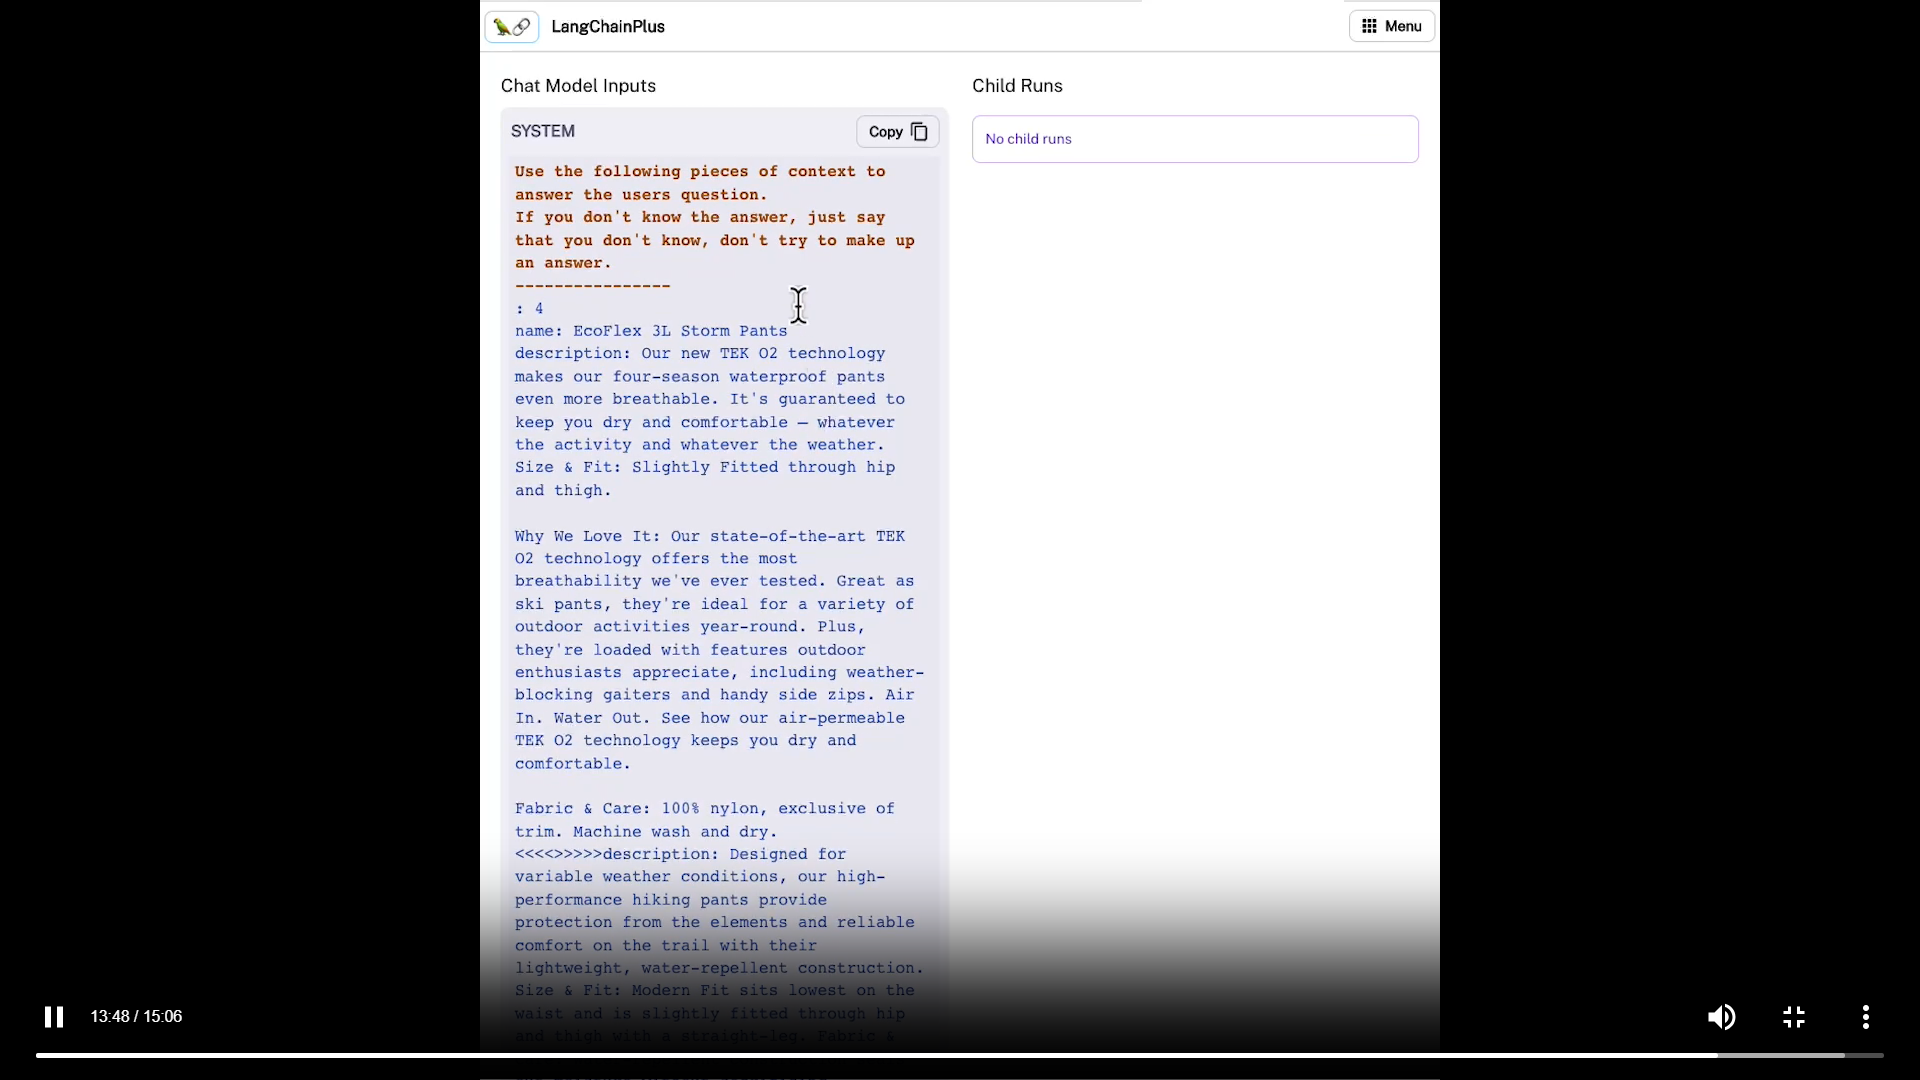

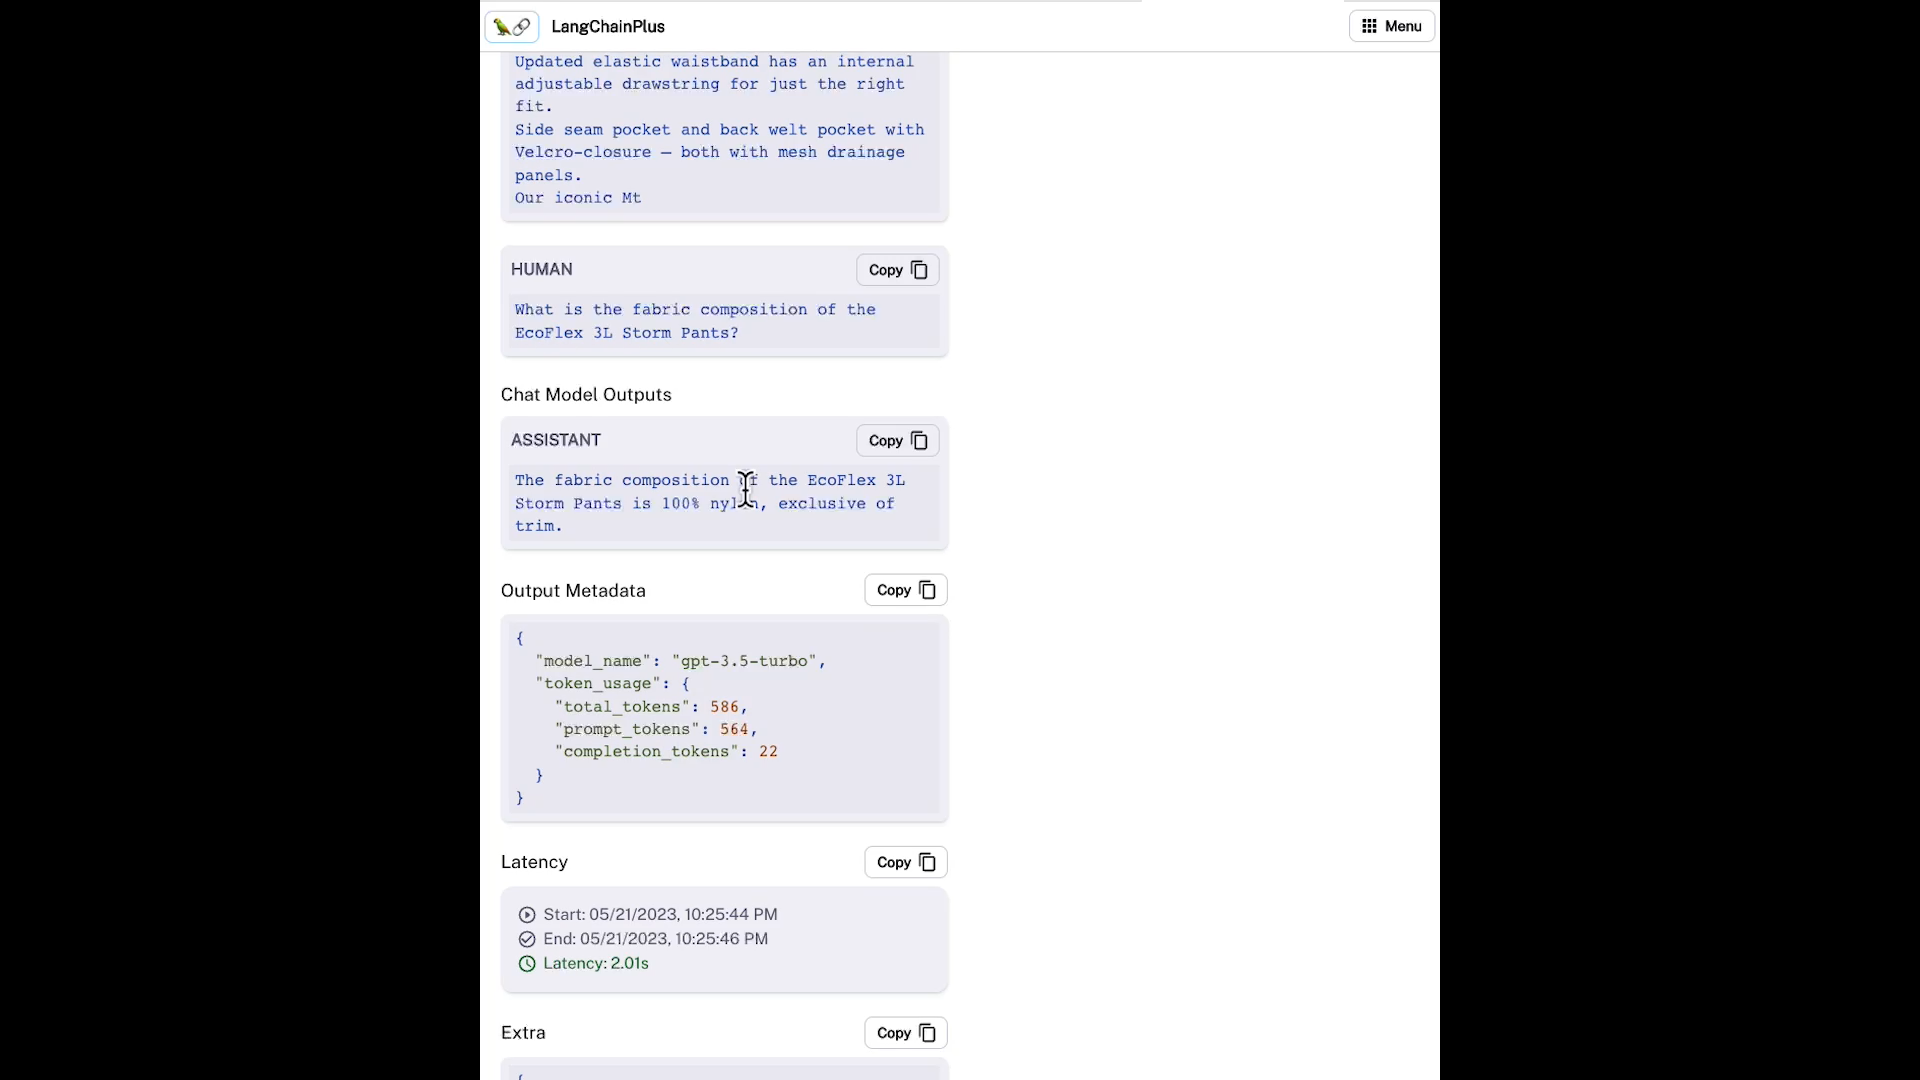

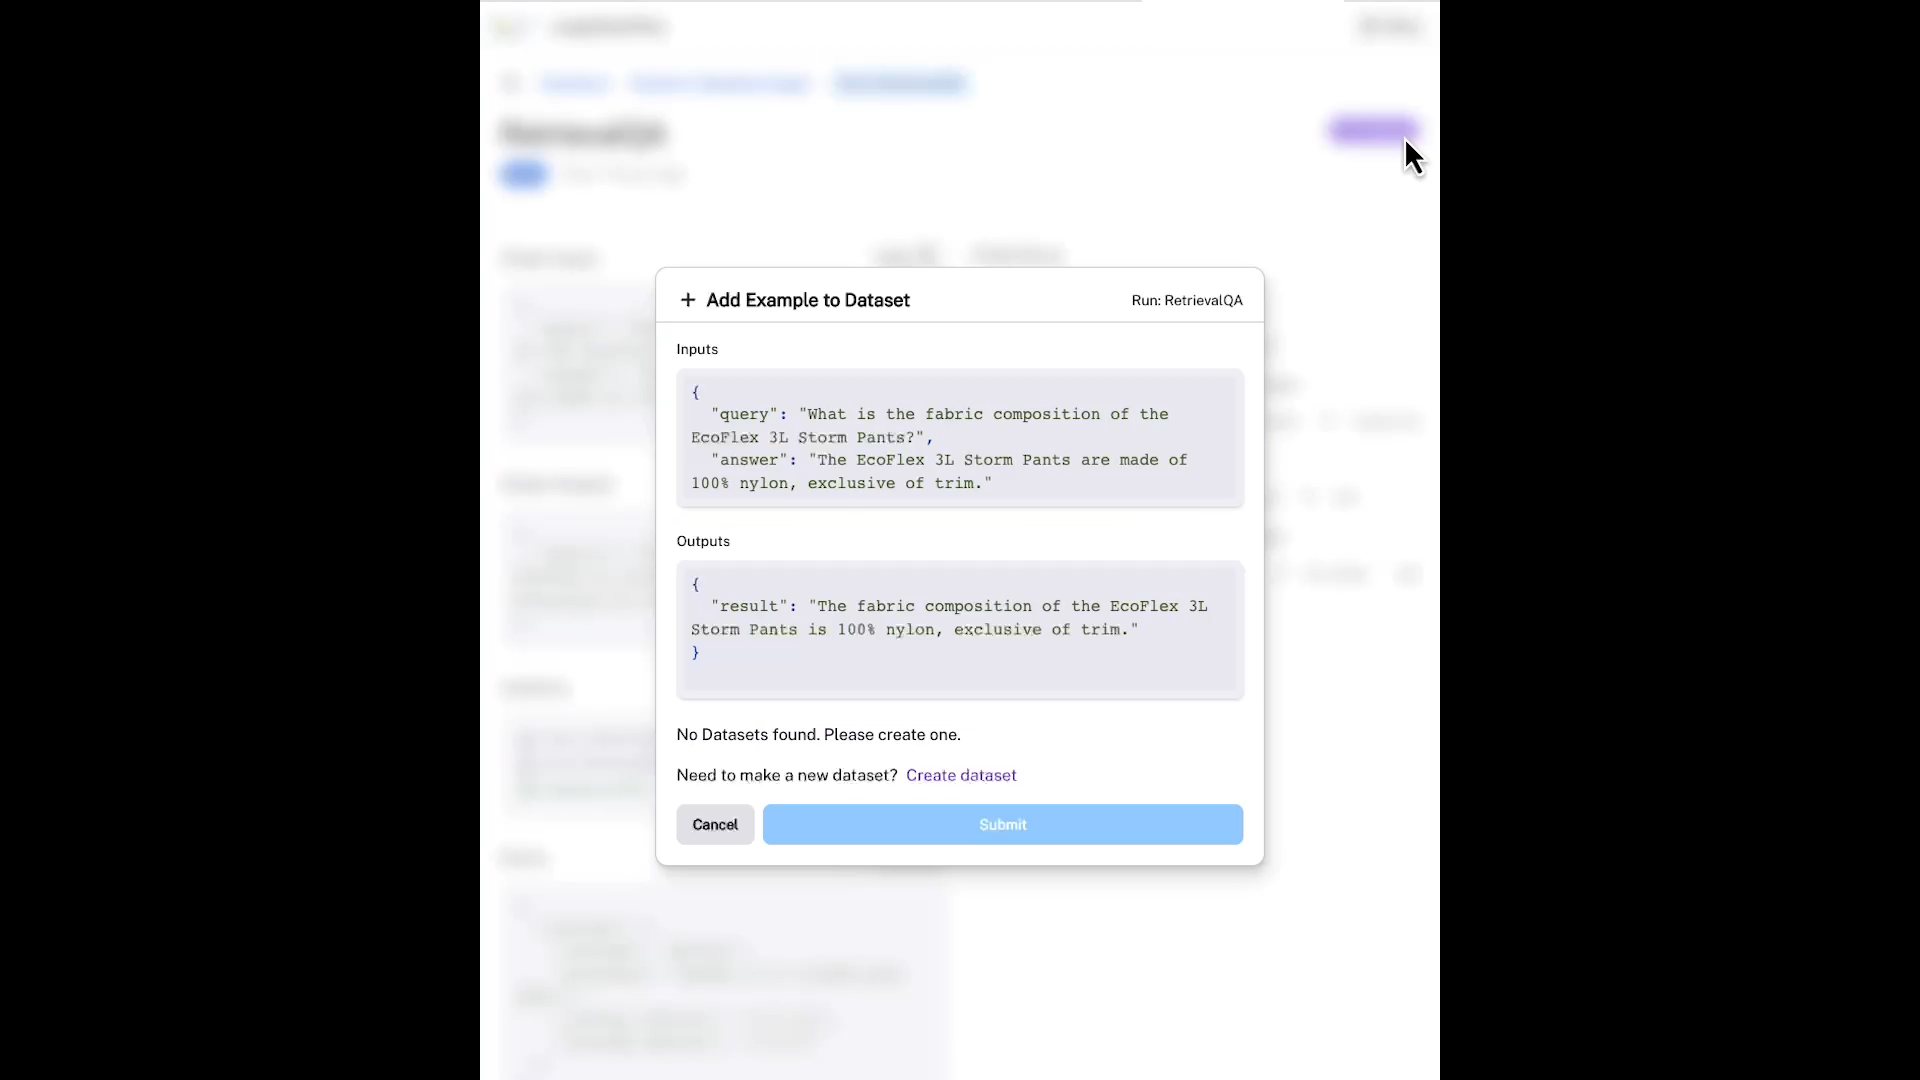